In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(54)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = fashion_mnist.load_data()

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


<ipython-input-4-84a179f8522e>:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()


In [5]:
#criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
#criterias = [(0, 50, 0), (50, 100, 75), (100, 125, 124), (125, 150, 149), (150, 175, 174), (175, 200, 199), (200, 225, 224), (225, 256, 255)]
#criterias = []
kernel_size = 3
#kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(kernel_size, scaler, classes, features, dim = 10000)

In [6]:
model.set_criterias(x, 10)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


In [ ]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [ ]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 50199.08it/s]


In [ ]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [ ]:
attacker = GenAttack(model, classes, 28 * 28, scaler, 0.6, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([0.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [ ]:
pops = []
results = []

In [ ]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [02:13<3:39:40, 133.14s/it]

All 5000 generations failed.


  2%|▏         | 2/100 [04:25<3:36:46, 132.72s/it]

All 5000 generations failed.


  3%|▎         | 3/100 [06:38<3:34:56, 132.96s/it]

All 5000 generations failed.


  4%|▍         | 4/100 [08:52<3:33:13, 133.26s/it]

All 5000 generations failed.


  5%|▌         | 5/100 [11:05<3:30:41, 133.07s/it]

All 5000 generations failed.


  6%|▌         | 6/100 [13:22<3:30:53, 134.61s/it]

All 5000 generations failed.


  7%|▋         | 7/100 [15:36<3:28:21, 134.43s/it]

All 5000 generations failed.


  8%|▊         | 8/100 [18:01<3:31:15, 137.77s/it]

All 5000 generations failed.


  9%|▉         | 9/100 [20:14<3:26:36, 136.22s/it]

All 5000 generations failed.


 10%|█         | 10/100 [20:15<2:21:47, 94.53s/it]

All candidates died at generation 43
Target =  tensor(9, device='cuda:0')


 11%|█         | 11/100 [22:29<2:37:48, 106.39s/it]

All 5000 generations failed.


 12%|█▏        | 12/100 [24:40<2:47:21, 114.10s/it]

All 5000 generations failed.


 13%|█▎        | 13/100 [26:54<2:53:53, 119.93s/it]

All 5000 generations failed.


 14%|█▍        | 14/100 [29:06<2:57:19, 123.72s/it]

All 5000 generations failed.


 15%|█▌        | 15/100 [31:22<3:00:24, 127.34s/it]

All 5000 generations failed.


 16%|█▌        | 16/100 [33:35<3:00:45, 129.11s/it]

All 5000 generations failed.


 17%|█▋        | 17/100 [35:48<3:00:00, 130.13s/it]

All 5000 generations failed.


 18%|█▊        | 18/100 [38:00<2:58:46, 130.81s/it]

All 5000 generations failed.


 19%|█▉        | 19/100 [40:13<2:57:20, 131.36s/it]

All 5000 generations failed.


 20%|██        | 20/100 [42:26<2:55:45, 131.82s/it]

All 5000 generations failed.


 21%|██        | 21/100 [44:38<2:53:49, 132.02s/it]

All 5000 generations failed.


 22%|██▏       | 22/100 [46:54<2:52:58, 133.06s/it]

All 5000 generations failed.


 23%|██▎       | 23/100 [49:07<2:50:51, 133.13s/it]

All 5000 generations failed.


 24%|██▍       | 24/100 [51:21<2:49:05, 133.49s/it]

All 5000 generations failed.


 25%|██▌       | 25/100 [53:34<2:46:31, 133.23s/it]

All 5000 generations failed.


 26%|██▌       | 26/100 [55:48<2:44:33, 133.43s/it]

All 5000 generations failed.


 27%|██▋       | 27/100 [58:05<2:43:55, 134.74s/it]

All 5000 generations failed.


 28%|██▊       | 28/100 [1:00:19<2:41:05, 134.25s/it]

All 5000 generations failed.


 29%|██▉       | 29/100 [1:02:29<2:37:31, 133.12s/it]

All 5000 generations failed.


 30%|███       | 30/100 [1:04:43<2:35:44, 133.49s/it]

All 5000 generations failed.


 31%|███       | 31/100 [1:07:00<2:34:34, 134.42s/it]

All 5000 generations failed.


 32%|███▏      | 32/100 [1:09:13<2:31:43, 133.88s/it]

All 5000 generations failed.


 33%|███▎      | 33/100 [1:11:34<2:32:10, 136.27s/it]

All 5000 generations failed.


 34%|███▍      | 34/100 [1:13:50<2:29:43, 136.12s/it]

All 5000 generations failed.


 35%|███▌      | 35/100 [1:16:04<2:26:34, 135.30s/it]

All 5000 generations failed.


 36%|███▌      | 36/100 [1:18:18<2:24:07, 135.12s/it]

All 5000 generations failed.


 37%|███▋      | 37/100 [1:20:41<2:24:15, 137.39s/it]

All 5000 generations failed.


 38%|███▊      | 38/100 [1:22:55<2:20:53, 136.34s/it]

All 5000 generations failed.


 39%|███▉      | 39/100 [1:25:08<2:17:30, 135.26s/it]

All 5000 generations failed.


 40%|████      | 40/100 [1:27:21<2:14:34, 134.58s/it]

All 5000 generations failed.


 41%|████      | 41/100 [1:27:24<1:33:43, 95.31s/it] 

Attack Success at generation 141


 42%|████▏     | 42/100 [1:29:42<1:44:27, 108.07s/it]

All 5000 generations failed.


 43%|████▎     | 43/100 [1:31:54<1:49:33, 115.32s/it]

All 5000 generations failed.


 44%|████▍     | 44/100 [1:34:07<1:52:25, 120.46s/it]

All 5000 generations failed.


 45%|████▌     | 45/100 [1:36:23<1:54:50, 125.28s/it]

All 5000 generations failed.


 46%|████▌     | 46/100 [1:38:36<1:54:43, 127.48s/it]

All 5000 generations failed.


 47%|████▋     | 47/100 [1:40:48<1:53:53, 128.94s/it]

All 5000 generations failed.


 48%|████▊     | 48/100 [1:43:00<1:52:22, 129.66s/it]

All 5000 generations failed.


 49%|████▉     | 49/100 [1:45:12<1:51:00, 130.59s/it]

All 5000 generations failed.


 50%|█████     | 50/100 [1:47:25<1:49:12, 131.06s/it]

All 5000 generations failed.


 51%|█████     | 51/100 [1:49:38<1:47:33, 131.71s/it]

All 5000 generations failed.


 52%|█████▏    | 52/100 [1:51:50<1:45:22, 131.73s/it]

All 5000 generations failed.


 53%|█████▎    | 53/100 [1:54:05<1:44:05, 132.88s/it]

All 5000 generations failed.


 54%|█████▍    | 54/100 [1:56:20<1:42:23, 133.54s/it]

All 5000 generations failed.


 55%|█████▌    | 55/100 [1:58:33<1:39:53, 133.18s/it]

All 5000 generations failed.


 56%|█████▌    | 56/100 [2:00:48<1:38:05, 133.77s/it]

All 5000 generations failed.


 57%|█████▋    | 57/100 [2:03:01<1:35:43, 133.57s/it]

All 5000 generations failed.


 58%|█████▊    | 58/100 [2:05:13<1:33:16, 133.25s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [2:07:27<1:31:12, 133.47s/it]

All 5000 generations failed.


 60%|██████    | 60/100 [2:09:42<1:29:17, 133.93s/it]

All 5000 generations failed.


 61%|██████    | 61/100 [2:11:57<1:27:15, 134.24s/it]

All 5000 generations failed.


 62%|██████▏   | 62/100 [2:12:44<1:08:27, 108.09s/it]

Attack Success at generation 1759


 63%|██████▎   | 63/100 [2:12:56<48:49, 79.16s/it]   

Attack Success at generation 439


 64%|██████▍   | 64/100 [2:15:08<57:04, 95.12s/it]

All 5000 generations failed.


 65%|██████▌   | 65/100 [2:17:21<1:01:58, 106.24s/it]

All 5000 generations failed.


 66%|██████▌   | 66/100 [2:19:33<1:04:41, 114.17s/it]

All 5000 generations failed.


 67%|██████▋   | 67/100 [2:20:37<54:24, 98.93s/it]   

Attack Success at generation 2359


 68%|██████▊   | 68/100 [2:22:56<59:11, 110.98s/it]

All 5000 generations failed.


 69%|██████▉   | 69/100 [2:25:10<1:01:00, 118.08s/it]

All 5000 generations failed.


 70%|███████   | 70/100 [2:27:23<1:01:12, 122.42s/it]

All 5000 generations failed.


 71%|███████   | 71/100 [2:28:43<53:06, 109.88s/it]  

Attack Success at generation 3079


 72%|███████▏  | 72/100 [2:30:58<54:44, 117.31s/it]

All 5000 generations failed.


 73%|███████▎  | 73/100 [2:33:11<54:54, 122.00s/it]

All 5000 generations failed.


 74%|███████▍  | 74/100 [2:35:24<54:14, 125.17s/it]

All 5000 generations failed.


 75%|███████▌  | 75/100 [2:37:36<53:02, 127.31s/it]

All 5000 generations failed.


 76%|███████▌  | 76/100 [2:39:48<51:32, 128.85s/it]

All 5000 generations failed.


 77%|███████▋  | 77/100 [2:42:01<49:49, 129.98s/it]

All 5000 generations failed.


 78%|███████▊  | 78/100 [2:44:13<47:56, 130.73s/it]

All 5000 generations failed.


 79%|███████▉  | 79/100 [2:46:27<46:03, 131.60s/it]

All 5000 generations failed.


 80%|████████  | 80/100 [2:48:45<44:29, 133.46s/it]

All 5000 generations failed.


 81%|████████  | 81/100 [2:50:58<42:12, 133.31s/it]

All 5000 generations failed.


 82%|████████▏ | 82/100 [2:53:16<40:26, 134.81s/it]

All 5000 generations failed.


 83%|████████▎ | 83/100 [2:55:30<38:06, 134.50s/it]

All 5000 generations failed.


 84%|████████▍ | 84/100 [2:57:42<35:41, 133.84s/it]

All 5000 generations failed.


 85%|████████▌ | 85/100 [2:59:57<33:31, 134.09s/it]

All 5000 generations failed.


 86%|████████▌ | 86/100 [2:59:58<21:56, 94.07s/it] 

All candidates died at generation 24
Target =  tensor(2, device='cuda:0')


 87%|████████▋ | 87/100 [3:02:11<22:55, 105.81s/it]

All 5000 generations failed.


 88%|████████▊ | 88/100 [3:04:27<22:58, 114.85s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [3:06:39<22:02, 120.20s/it]

All 5000 generations failed.


 90%|█████████ | 90/100 [3:08:54<20:43, 124.39s/it]

All 5000 generations failed.


 91%|█████████ | 91/100 [3:11:06<19:01, 126.84s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [3:13:19<17:08, 128.61s/it]

All 5000 generations failed.


 93%|█████████▎| 93/100 [3:15:33<15:12, 130.37s/it]

All 5000 generations failed.


 94%|█████████▍| 94/100 [3:17:45<13:05, 130.88s/it]

All 5000 generations failed.


 95%|█████████▌| 95/100 [3:20:02<11:02, 132.56s/it]

All 5000 generations failed.


 96%|█████████▌| 96/100 [3:22:17<08:53, 133.35s/it]

All 5000 generations failed.


 97%|█████████▋| 97/100 [3:24:38<06:46, 135.64s/it]

All 5000 generations failed.


 98%|█████████▊| 98/100 [3:26:51<04:29, 134.72s/it]

All 5000 generations failed.


 99%|█████████▉| 99/100 [3:29:03<02:13, 133.95s/it]

All 5000 generations failed.


100%|██████████| 100/100 [3:31:15<00:00, 126.76s/it]

All 5000 generations failed.
t = 12675.608986


In [ ]:
pops = np.array(pops)

In [ ]:
sample_preds = preds[indices]

In [ ]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [ ]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

5


In [ ]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [ ]:
torch.save(cache, 'robust_onlinehd_fashion_mnist.pt')

In [ ]:
model(torch.tensor(pops[0]))

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [ ]:
labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

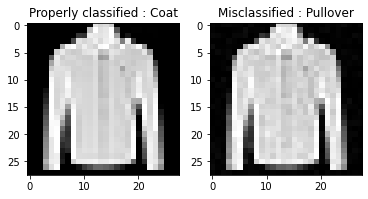

In [ ]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])